This is the Notebook containing code for Hate Speech Classifier using Fine-Tuning of Bert model 

Installing and Importing necessary libraries

In [ ]:
pip install transformers datasets torch

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


Setting Device as CPU

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Loading the dataset and preprocessing the data

In [4]:
from datasets import load_dataset

dataset = load_dataset("hate_speech18")  #hate_speech18 dataset is taken from HuggingFace datasets             

In [5]:
df = pd.DataFrame(dataset["train"])  #Converting it to dataframe for easier preprocessing
df

,text,user_id,subforum_id,num_contexts,label
0,"As of March 13th , 2014 , the booklet had been...",572066,1346,0,0
1,In order to help increase the booklets downloa...,572066,1346,0,0
2,( Simply copy and paste the following text int...,572066,1346,0,0
3,Click below for a FREE download of a colorfull...,572066,1346,0,1
4,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...,572066,1346,0,0
...,...,...,...,...,...
10939,"Billy - `` That guy would n't leave me alone ,...",734541,1388,0,0
10940,Wish we at least had a Marine Le Pen to vote f...,735154,1388,0,0
10941,Its like the choices are white genocide candid...,735154,1388,0,0
10942,Why White people used to say that sex was a si...,572266,1388,0,1


In [6]:
from string import punctuation
punctuation = list(punctuation)
stop_words = stopwords.words("english")

def preprocess(sentence):           #Removing stopwords and punctuations from each sentence, and converting it to lower case
  tokens = sentence.split(" ")
  formatted_tokens = []
  for word in tokens:
    letters = [x for x in word if x not in punctuation]
    no_punc_word = ""
    for punc in letters:
      if punc in punctuation:
        continue
      else:
        no_punc_word += punc
    formatted_tokens.append(no_punc_word)
  final_tokens = [word.lower() for word in formatted_tokens if word.lower() not in stop_words]
  return final_tokens

df['text'] = df['text'].apply(lambda x: preprocess(x))
df['text'] = df['text'].apply(lambda x: [y for y in x if y != ''])
df['text'] = df['text'].apply(lambda x: " ".join(x))
df

,text,user_id,subforum_id,num_contexts,label
0,march 13th 2014 booklet downloaded 18300 times...,572066,1346,0,0
1,order help increase booklets downloads would g...,572066,1346,0,0
2,simply copy paste following text youtube video...,572066,1346,0,0
3,click free download colorfully illustrated 132...,572066,1346,0,1
4,click download 742 mb green banner link,572066,1346,0,0
...,...,...,...,...,...
10939,billy guy would nt leave alone gave trudeau sa...,734541,1388,0,0
10940,wish least marine le pen vote canada,735154,1388,0,0
10941,like choices white genocide candidate 1 2 3,735154,1388,0,0
10942,white people used say sex sin used mystery saw...,572266,1388,0,1


In [7]:
def assign(x):      #Cleaning and modifying faults in labels of data
  if x>=1:
    x = 1
    return x
  else:
    return 0
df['label'] = df['label'].apply(lambda x: assign(x))

In [8]:
speeches = df.text.values    #Creating lists out of columns of dataframe
labels = df.label.values

Model Chosen is Bert for Sequence classification

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)    #Importing tokenizer suited for Bert

In [10]:
print("Original:", speeches[0])
print("Tokenized:", tokenizer.tokenize(speeches[0]))
print("ID:", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(speeches[0])))

Original: march 13th 2014 booklet downloaded 18300 times counting
Tokenized: ['march', '13th', '2014', 'booklet', 'downloaded', '1830', '##0', 'times', 'counting']
ID: [2233, 6122, 2297, 19271, 22817, 9500, 2692, 2335, 10320]


In [11]:
max_length = 0

for speech in speeches:
  input_ids = tokenizer.encode(speech, add_special_tokens = True)
  temp = len(input_ids)
  max_length = max(temp, max_length)
print(max_length)

392


In [12]:
input_ids = []            #Converting each speech to input ids and creating corresponding attention masks
attention_masks = []

for speech in speeches:
  enc_dict = tokenizer.encode_plus(speech, add_special_tokens = True, max_length = max_length, pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')

  input_ids.append(enc_dict['input_ids'])
  attention_masks.append(enc_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim = 0)        #Converting to Tensors, all three, input_ids, attention_masks and corresponding labels
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

print("Speech:", speeches[0])
print("Input ids:", input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Speech: march 13th 2014 booklet downloaded 18300 times counting
Input ids: tensor([  101,  2233,  6122,  2297, 19271, 22817,  9500,  2692,  2335, 10320,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,    

In [13]:
dataset = TensorDataset(input_ids, attention_masks, labels)

train_len = int(0.8*len(dataset))
test_len = len(dataset) - train_len

train_dataset, test_dataset = random_split(dataset, [train_len, test_len])   #Splitting Dataset for training and evaluation
print(train_len)
print(test_len)

8755
2189


In [14]:
batch_size = 32     #Using the batch size of 32 for Dataloaders

train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
test_dataloader = DataLoader(test_dataset, sampler = RandomSampler(test_dataset), batch_size = batch_size)


Importing pretrained Bert Model

In [15]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2, output_attentions = False, output_hidden_states = False)
#model = model.cuda()
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with the help of PyTorch Framework

In [16]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
epochs = 4

training_steps = len(train_dataloader)*epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = training_steps)

In [18]:
def flattened_accuracy(preds, labels):        #For computing Accuracies
  pred_flat = np.argmax(preds, axis = 1).flatten()
  labels_flat = labels.flatten()
  n = 0
  for i in range(len(pred_flat) - 1):
    if pred_flat[i] == labels_flat[i]:
      n += 1
  accuracy = n/len(pred_flat)
  return accuracy

In [19]:
import time
import datetime
import gc
import random

In [20]:
def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds = elapsed_rounded))


In [21]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)        
        loss = output.loss
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    print("")
    print("Running Validation...")
    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        
            output= model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flattened_accuracy(logits, label_ids)
    avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(test_dataloader)
    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, 'bert_model')
        best_eval_accuracy = avg_val_accuracy
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.35
  Training epcoh took: 1:43:30

Running Validation...
  Accuracy: 0.86

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.24
  Training epcoh took: 1:41:35

Running Validation...
  Accuracy: 0.87

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.17
  Training epcoh took: 1:43:48

Running Validation...
  Accuracy: 0.87

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.12
  Training epcoh took: 1:41:43

Running Validation...
  Accuracy: 0.87

Training complete!
Total training took 7:11:53 (h:mm:ss)


Saving the Model

In [26]:
model_path = 'Desktop'

torch.save(model.state_dict(), model_path)

In [25]:
torch.save(model, 'FinalHateSpeechDetectingModel.pth')

Visualising accuracies and losses with the help of MatPLotLib

In [28]:
import matplotlib.pyplot as plt

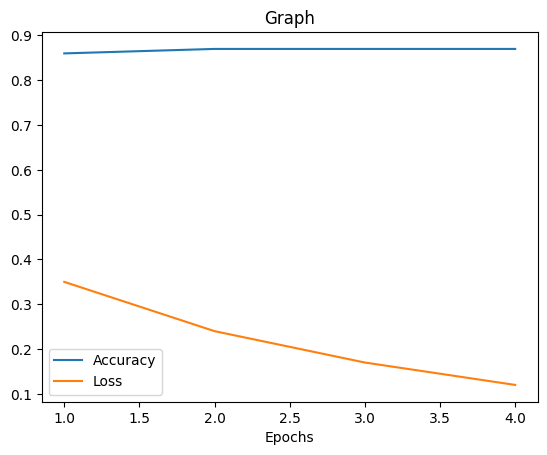

In [29]:
epochs = [1,2,3,4]
accuracies = [0.86,0.87,0.87, 0.87]
average_losses = [0.35,0.24,0.17, 0.12]
plt.plot(epochs, accuracies, label = "Accuracy")
plt.xlabel("Epochs")
plt.plot(epochs, average_losses, label = "Loss")
plt.legend()
plt.title("Graph")
plt.show()

Checking the Outputs and Using the Model

In [56]:
def Hate_NoHate(model, text):
    input = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**input)
        logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    if probabilities[0][1] >= 0.4:
        print("This is a Hate Speech")
    else:
        print("This is not a Hate speech")

In [67]:
text = "They have infected our society"
Hate_NoHate(model, text)

This is a Hate Speech


In [68]:
loaded_model = torch.load("FinalHateSpeechDetectingModel.pth")

In [79]:
text = "I like you"
Hate_NoHate(loaded_model, text)

This is not a Hate speech
